[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 6657806, number of used features: 10
[LightGBM] [Info] Start training from score 0.050074
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3342194, number of used features: 10
[LightGBM] [Info] Start training from score 0.901911
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

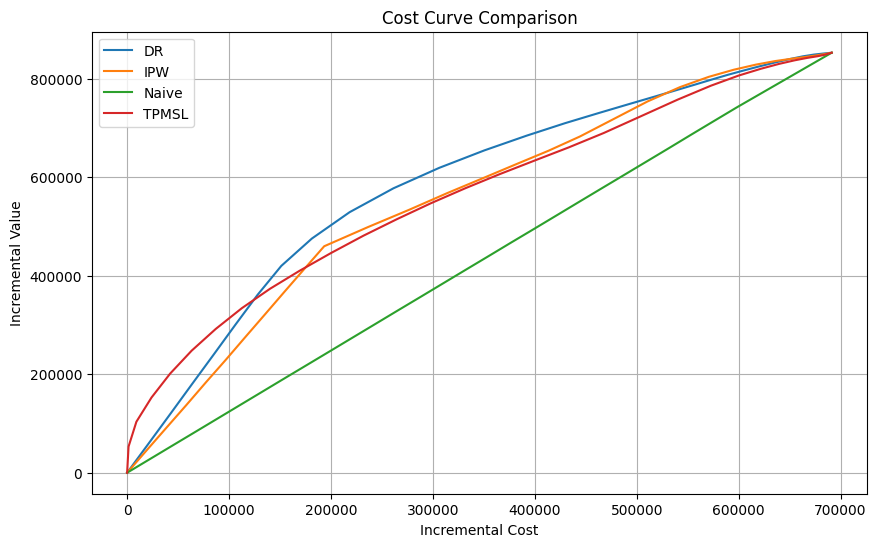

In [11]:
import non_RCT
import importlib
importlib.reload(non_RCT)
non_RCT.main()

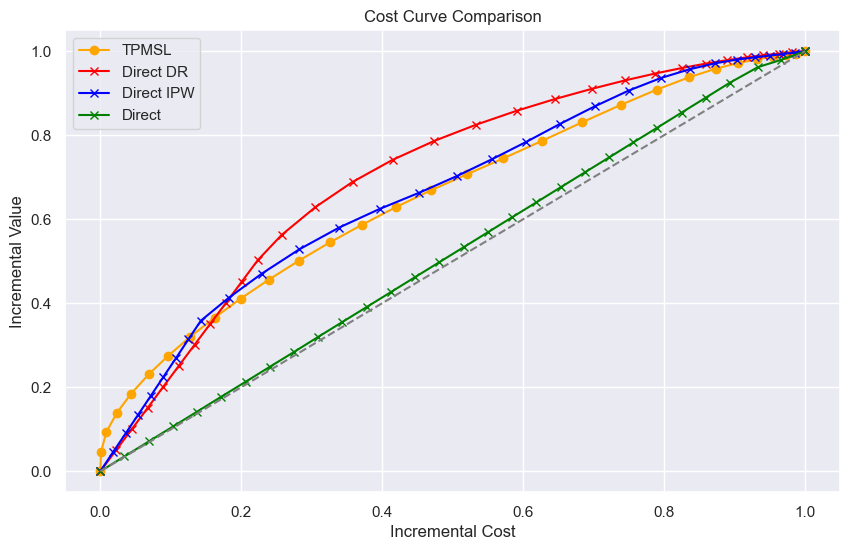

In [354]:
import matplotlib.pyplot as plt
# 横軸と縦軸を正規化してグラフ描画
plt.figure(figsize=(10, 6))
plt.plot(incremental_costs_tpmsl / max(incremental_costs_tpmsl), incremental_values_tpmsl / max(incremental_values_tpmsl), marker='o', color='orange',  label='TPMSL')
plt.plot(incremental_costs_direct / max(incremental_costs_direct), incremental_values_direct / max(incremental_values_direct), marker='x', color='red', label='Direct DR')
plt.plot(incremental_costs_direct_ipw / max(incremental_costs_direct_ipw), incremental_values_direct_ipw / max(incremental_values_direct_ipw), marker='x', color='blue', label='Direct IPW')
plt.plot(incremental_costs_direct_naive / max(incremental_costs_direct_naive), incremental_values_direct_naive / max(incremental_values_direct_naive), marker='x', color='green', label='Direct')
# y = x の直線
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Cost Curve Comparison')
plt.xlabel('Incremental Cost')
plt.ylabel('Incremental Value')
plt.legend()
plt.grid(True)
plt.show()